In [1]:
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undst = cv2.undistort(undist, mtx, dist, None, mtx)
    return undst

In [4]:
objpoints = []
imgpoints = []
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
for i, fname in enumerate(images):
    #print(fname)
    #print(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#undistorted = cal_undistort(img, objpoints, imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print(dist)
#print(mtx)

In [5]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
org_img = mpimg.imread('./camera_cal/calibration2.jpg')
undistorted = undistort(org_img)
img_size = (img.shape[1], img.shape[0])
print(img_size)

(1280, 720)


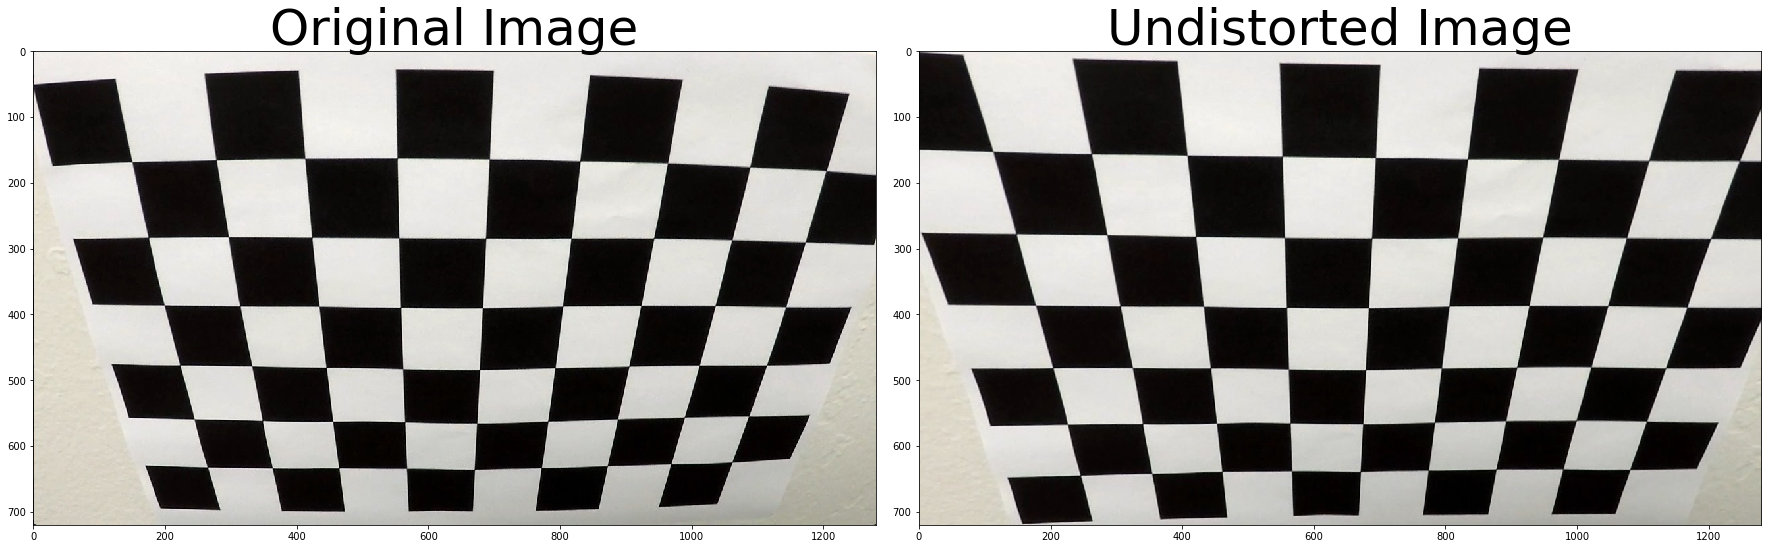

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


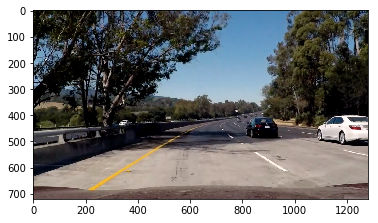

In [8]:
test_img = mpimg.imread('./test_images/test5.jpg')
plt.imshow(test_img)

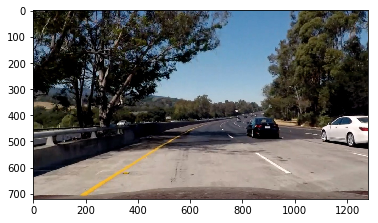

In [9]:
undistorted_img = cal_undistort(test_img, objpoints, imgpoints)
plt.imshow(undistorted_img)

In [10]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grdir=np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grdir)
    binary_output[(grdir >= thresh[0]) & (grdir <= thresh[1])] = 1
    return binary_output

def hls_image(img,thresh=(120,150)):
   height=img.shape[0]
   width=img.shape[1]
   hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
   h=hls[:,:,0]
   l=hls[:,:,1]
   s=hls[:,:,2]
   binary_hls=np.zeros_like(s)
   binary_hls[(l > thresh[0]) & (s > thresh[1])]=1
   return binary_hls


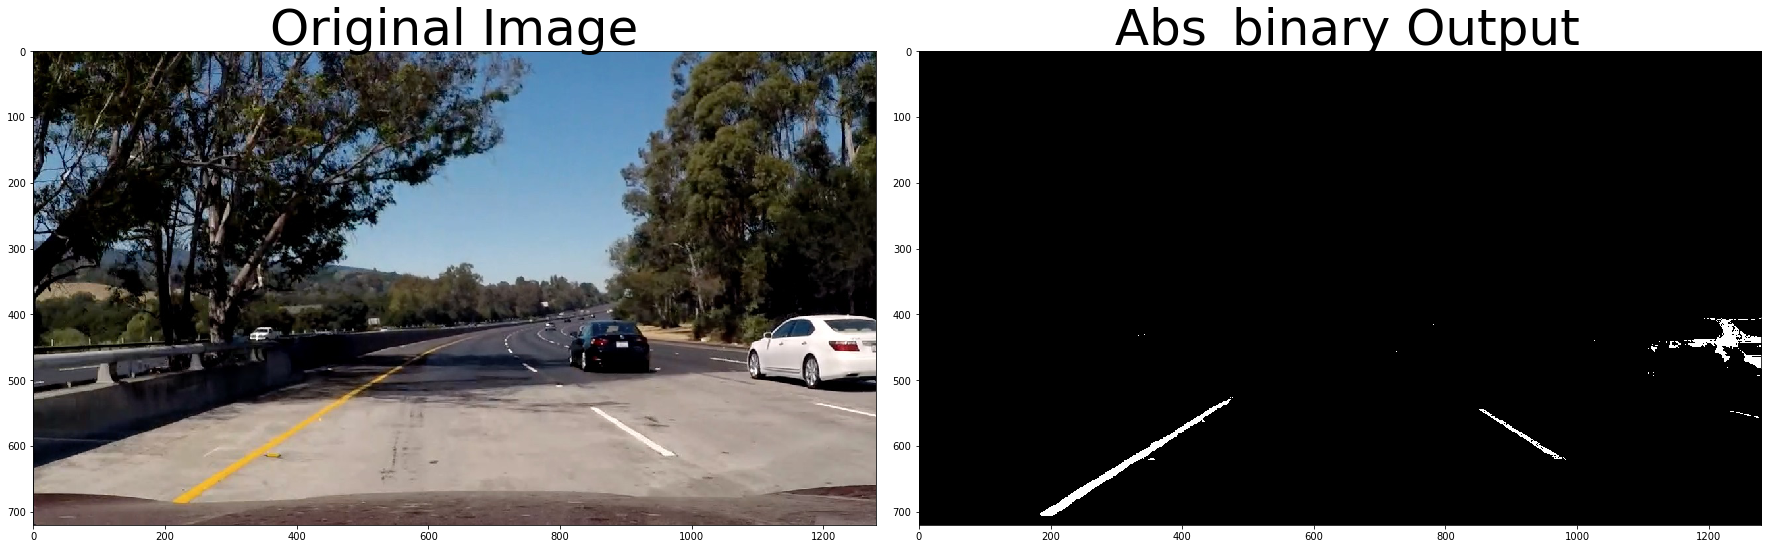

In [11]:
hls_binary = hls_image(undistorted_img, thresh=(120, 150))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title(' Abs_binary Output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def thresholded(undistorted_img):
    gradx = abs_sobel_thresh(undistorted_img, orient='x', thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted_img, orient='y', thresh=(60, 255))
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=3, mag_thresh=(40, 255))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=3, thresh=(.65, 1.05))
    #hls_binary = hls_image(undistorted_img, thresh=(120, 150))
    #hls_binary_h = hls_sthresh_h(undistorted_img, thresh=(120, 200))
    #hls_binary_l = hls_sthresh_l(undistorted_img, thresh=(90, 255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 130) & (s_channel <= 255)] = 1
    
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((==1))] = 1
    return combined

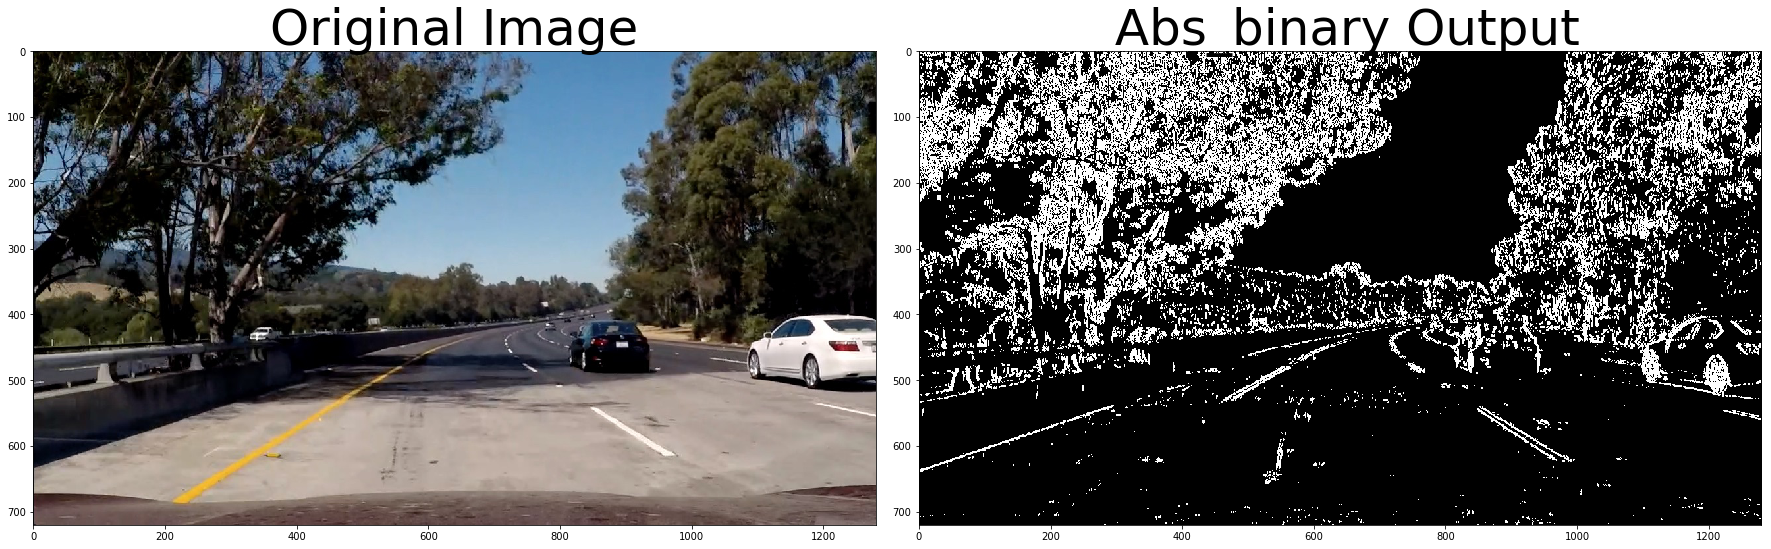

In [13]:
abs_binary = abs_sobel_thresh(undistorted_img, orient='x', thresh=(10, 255))
#print(thresh)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(abs_binary, cmap='gray')
ax2.set_title(' Abs_binary Output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

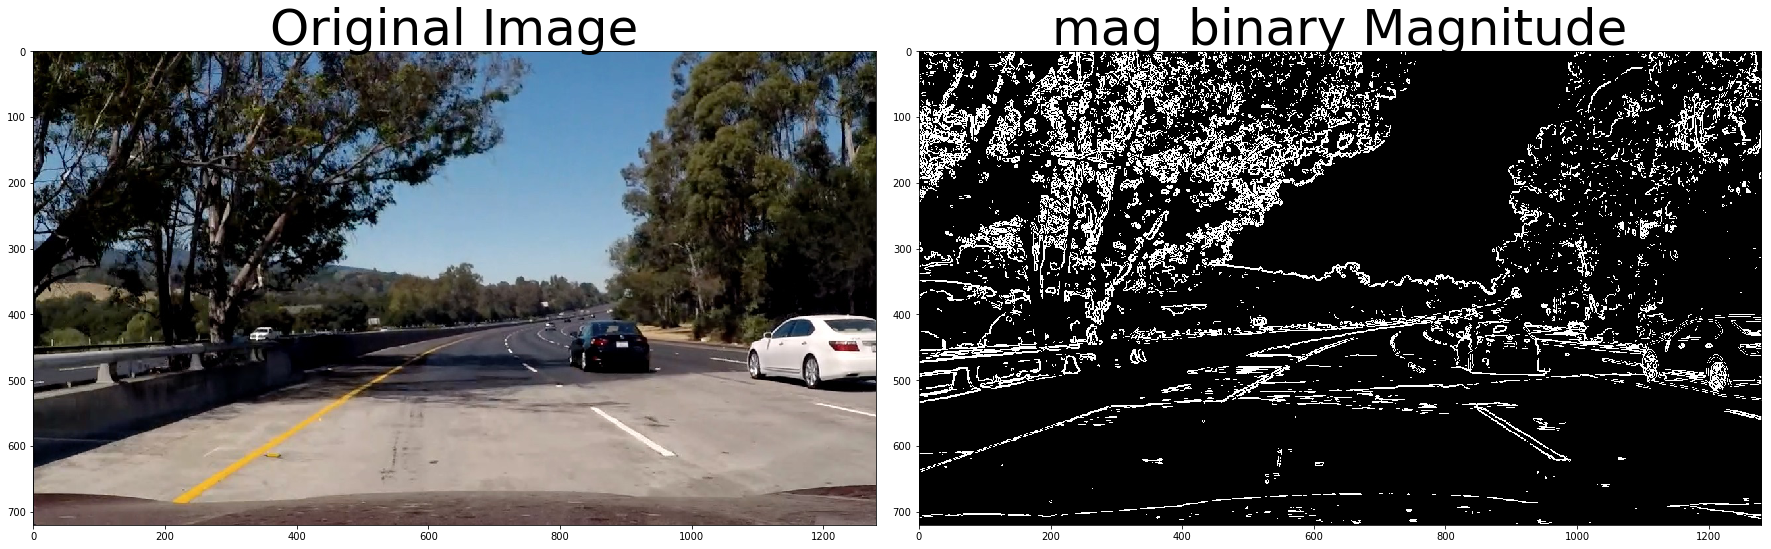

In [14]:
mag_binary = mag_thresh(undistorted_img, sobel_kernel=3, mag_thresh=(30, 100))
#print(mag_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('mag_binary Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

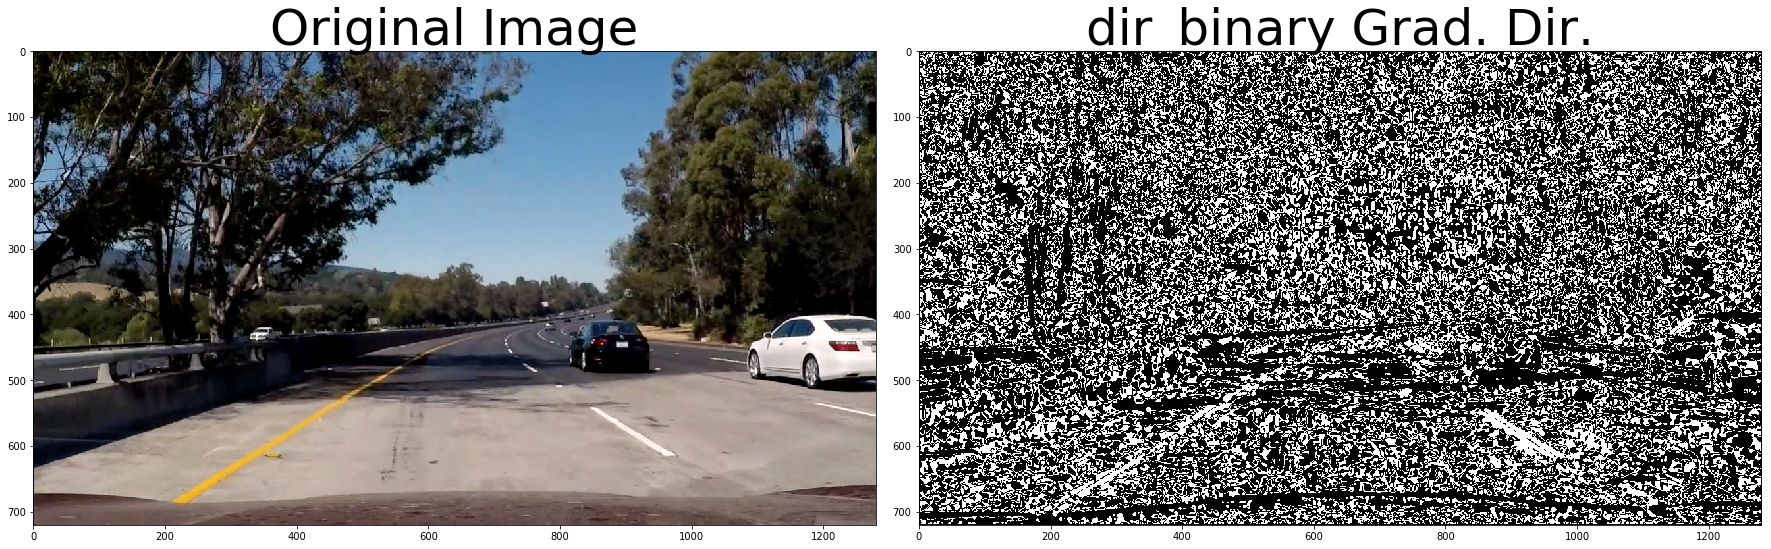

In [15]:
dir_binary = dir_threshold(undistorted_img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('dir_binary Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

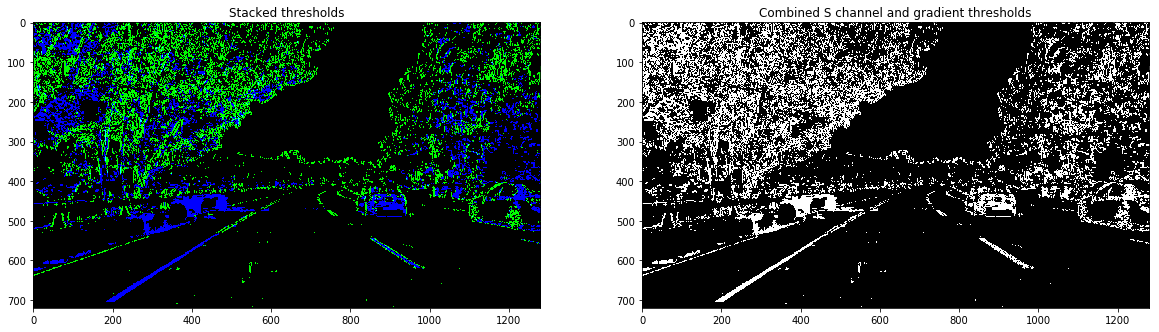

In [16]:
hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

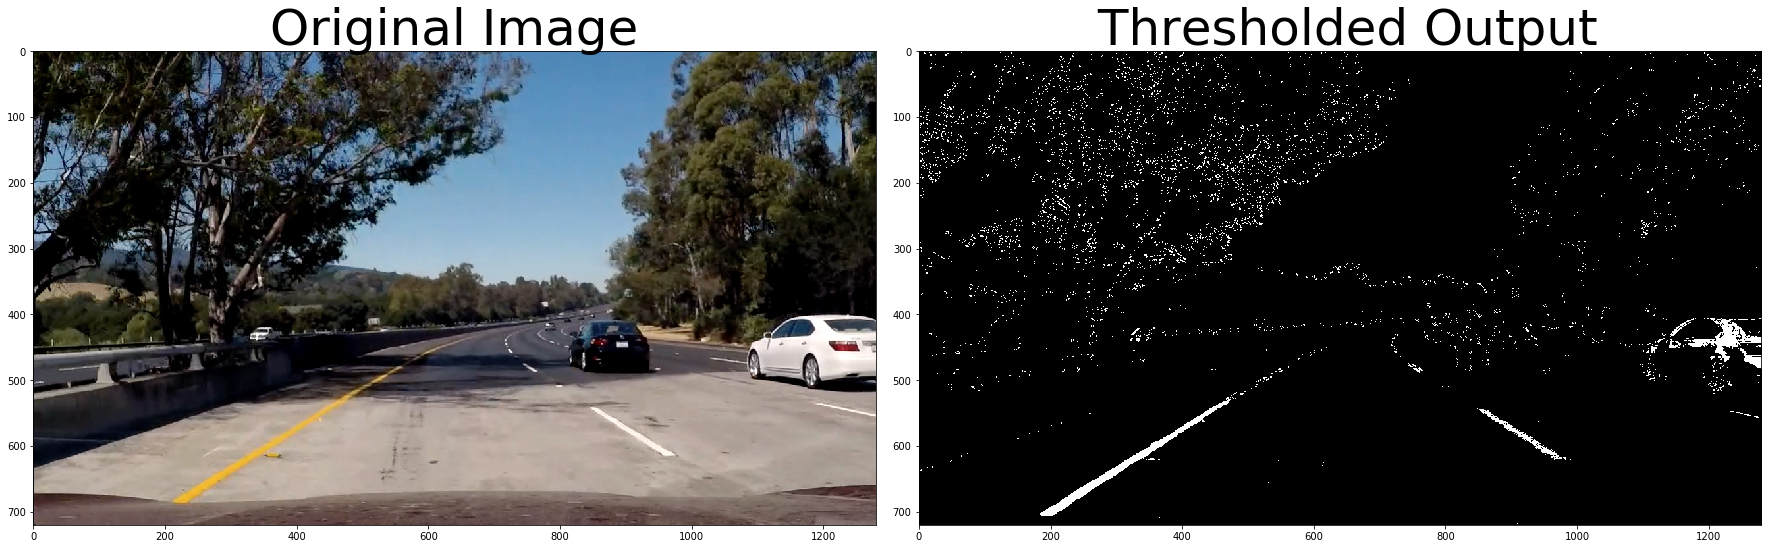

In [17]:
thresh_out = thresholded(undistorted_img)
#print(thresh)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresh_out, cmap='gray')
ax2.set_title(' Thresholded Output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
src = np.float32([(580,480),(740,480),(1150,699),(258,699)])
dst = np.float32([(260,0), (780,0),(780,720), (200,720)])
#src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
#dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
def unwarp_img(img):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size=(gray.shape[1],gray.shape[0])
    #print(img_size)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

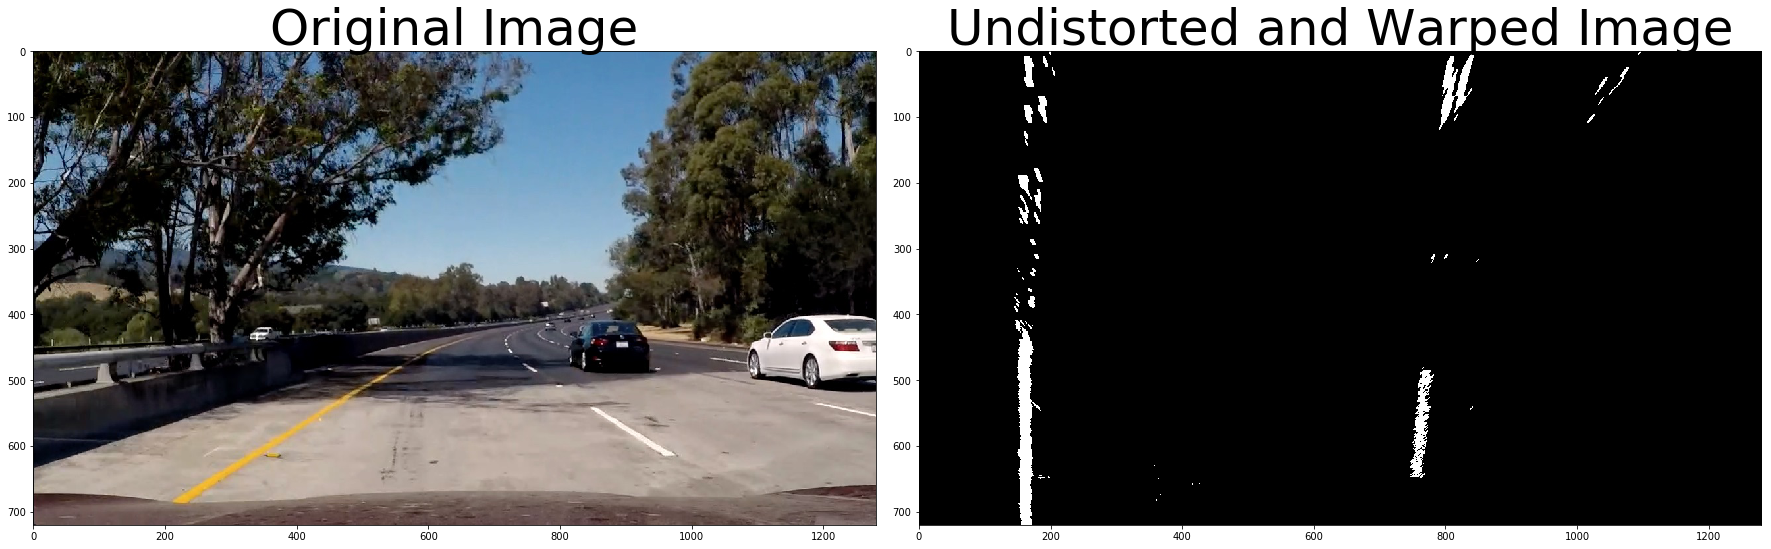

In [19]:
#plt.imshow(thresh_out, cmap='gray')
top_down, perspective_M = unwarp_img(thresh_out)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#src = np.float32([(580,464),(707,464),(258,679),(1050,679)])
#dst = np.float32([(260,0), (780,0), (200,720),(780,720)])

In [20]:
def pipeline(img):
    undistorted_img=undistort(img)
    thresholded_img=thresholded(undistorted_img)
    top_down2, perspective_M2 = unwarp_img(thresholded_img)
    wraped_top = top_down2
    #warpedtop =np.dstack((wraped_top,wraped_top,wraped_top))*255
    return wraped_top

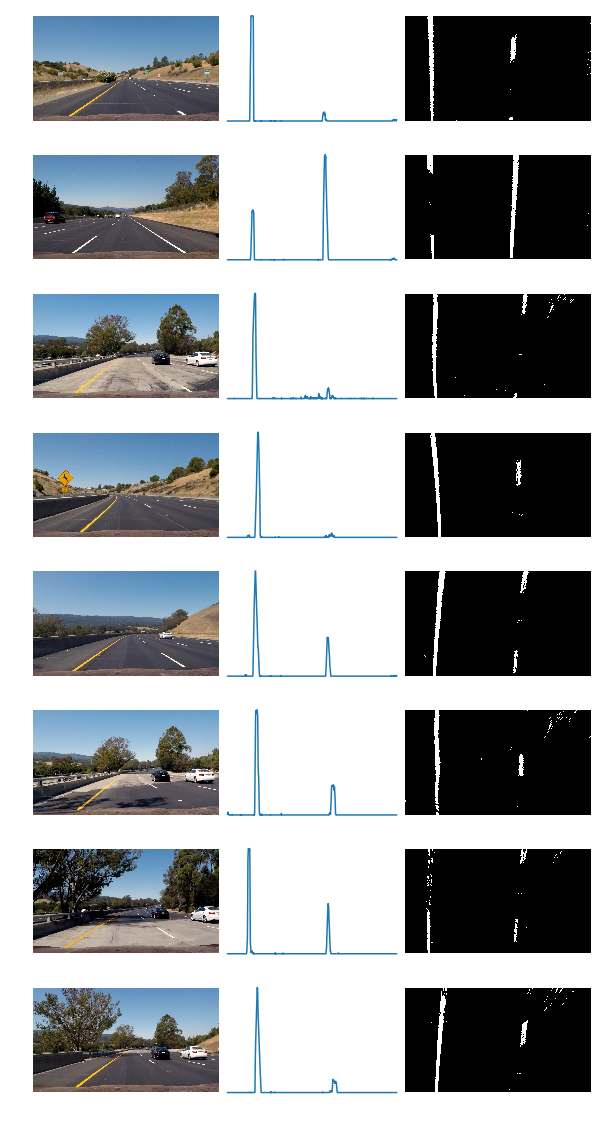

In [21]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
    axs[i].plot(histogram)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
 

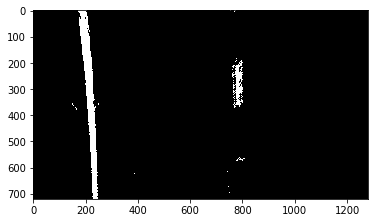

In [22]:
test_img1 = mpimg.imread('./test_images/test2.jpg')
plt.imshow(test_img1)
test_img1=undistort(test_img1)
abs_binary_ex=thresholded(test_img1)

abs_bin,M_new=unwarp_img(abs_binary_ex)
plt.imshow(abs_bin,cmap='gray')

In [23]:
def pipeline_new(img):
    img_size=(img.shape[1],img.shape[0])
    img_output = pipeline(img)
    img_bin=img_output
    #plt.imshow(img_hist)
    histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img_bin, img_bin, img_bin))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    # Set height of windows
    window_height = np.int(img_bin.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_bin.shape[0] - (window+1)*window_height
        win_y_high = img_bin.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)    
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(len(leftx))
    #print(len(lefty))
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    margin=(left_fitx+right_fitx)/2
    #print(margin)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img_bin, img_bin, img_bin))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    M_inve = cv2.getPerspectiveTransform(dst, src)
    win_img=cv2.warpPerspective(window_img, M_inve, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, win_img, 0.3, 0)
    
    return result

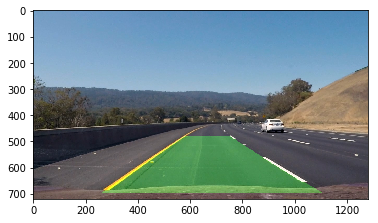

In [24]:
image_to_test = mpimg.imread('./test_images/test3.jpg')
plt.imshow(image_to_test)

result = pipeline_new(image_to_test)
plt.imshow(result)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_out6.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline_new) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out6.mp4
[MoviePy] Writing video project_video_out6.mp4


  9%|███████▏                                                                       | 114/1261 [00:32<06:20,  3.01it/s]